# 4주차 Vision Basic 과제

### 1. 이미지 처리에 있어 Traditional 신경망이 가지는 문제

In [1]:
from torchvision import datasets
import torch
data_folder = './data' # 해당 경로 폴더에 FashionMNIST 데이터셋을 다운로드
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:07<00:00, 3584927.24it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136689.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 497457.72it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5174281.57it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [34]:
# 학습 이미지와 레이블
tr_images = fmnist.data
tr_targets = fmnist.targets

In [31]:
# 평가 이미지와 레이블
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

(28, 28)


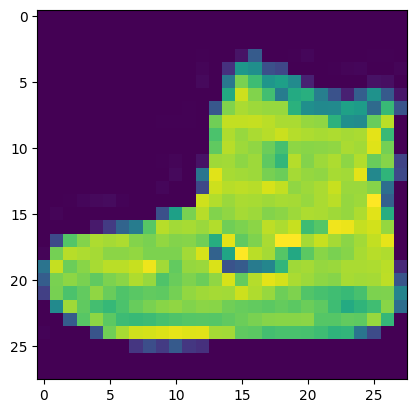

In [32]:
## 이미지 시각화 및 크기 확인

import PIL.Image as Image
import matplotlib.pyplot as plt
img = Image.fromarray(tr_images[0].numpy())
plt.imshow(img)
print(img.size)

In [35]:
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [36]:
# FashionMNIST 데이터셋을 Dataset 클래스로 만들기

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD, Adam

# 간단한 Linear 신경망 정의

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [37]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [38]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [39]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [40]:
# 정의한 모델을 이용하여 학습, 평가
# epoch 당 loss, accuracy 저장 및 출력

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch : {epoch}" )
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    print(f"train_loss : {train_epoch_loss:.4f}, train_accuracy : {train_epoch_accuracy:.4f}, val_loss : {validation_loss:.4f}, val_accuracy : {val_epoch_accuracy:.4f}")

epoch : 0
train_loss : 0.4786, train_accuracy : 0.8679, val_loss : 0.4144, val_accuracy : 0.8550
epoch : 1
train_loss : 0.3583, train_accuracy : 0.8838, val_loss : 0.3696, val_accuracy : 0.8657
epoch : 2
train_loss : 0.3232, train_accuracy : 0.8935, val_loss : 0.3545, val_accuracy : 0.8732
epoch : 3
train_loss : 0.2960, train_accuracy : 0.8981, val_loss : 0.3421, val_accuracy : 0.8759
epoch : 4
train_loss : 0.2764, train_accuracy : 0.8947, val_loss : 0.3678, val_accuracy : 0.8705


- 학습 데이터셋의 Index 24300 (무작위 인덱스) 이미지를 학습 모델에 투입하여 예측값 확인
  - Trouser 클래스(1번 클래스)의 확률이 가장 큼

Text(0.5, 1.0, 'Trouser')

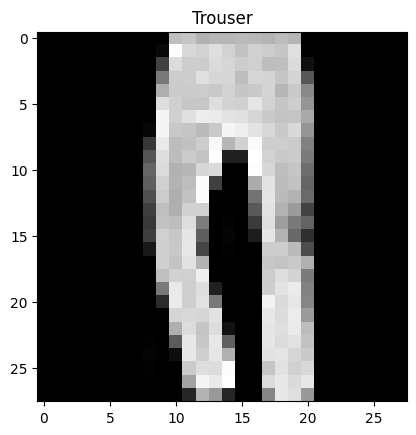

In [11]:
#ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

- Translation
  - np.roll 함수를 사용하여 Index 24300 이미지를 좌우로 이동 (범위 -5~+5)

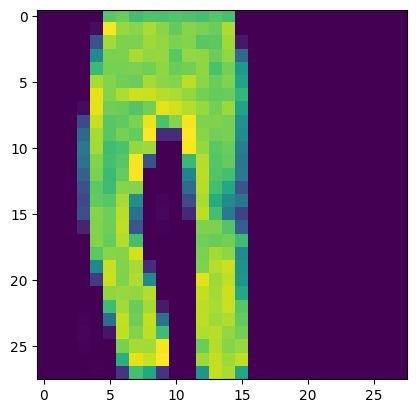

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [784]

In [29]:
preds = []
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

#### 결과 확인

ValueError: Must pass 2-d input. shape=(11, 1, 10)

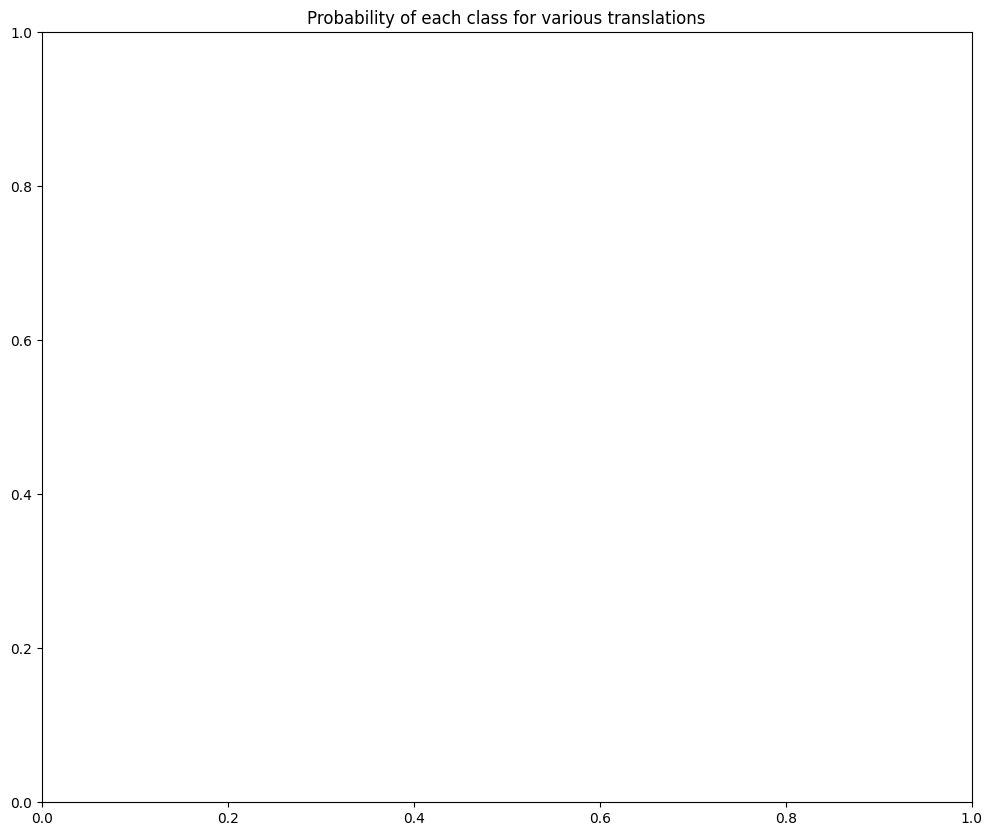

In [28]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

#### 인사이트를 적어주세요.

- 위 히트맵에서 세로축은 동일한 이미지를 좌우로 이동한 픽셀 수를 나타내며,
- 가로축은 각 클래스에 대한 확률을 나타냅니다.

In [ ]:
# 이미지를 픽셀 단위로 수직 이동할 때 마다 분류확률에 큰 변동이 있다. 또한 특정 클래스에 대한 확률이 매우 높은 값을 보이는 경우가 있는데 이는 특정 데이터 포인트에 과적합될 가능성을 보여준다.

### 2. 합성곱 신경망 활용, FashionMNIST 이미지 분류

In [14]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

- 아래 모델 summary를 보고 컨폴루션 레이어 안의 파라미터를 작성해주세요.
- stride = 1 (default), padding = 0으로 통일입니다.

In [19]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,32 , kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(32,64 , kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64*5*5,128 ),
        nn.ReLU(),
        nn.Linear(128,10 )
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [20]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [21]:
trn_dl, val_dl = get_data()

In [22]:
#!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model,(1,28,28));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 13, 13]               0
              ReLU-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,496
         MaxPool2d-5             [-1, 64, 5, 5]               0
              ReLU-6             [-1, 64, 5, 5]               0
           Flatten-7                 [-1, 1600]               0
            Linear-8                  [-1, 128]         204,928
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 0.86
Estimated T

In [23]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch : {epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"train_loss : {train_epoch_loss:.4f}, train_accuracy : {train_epoch_accuracy:.4f}, val_loss : {validation_loss:.4f}, val_accuracy : {val_epoch_accuracy:.4f}")

epoch : 0
train_loss : 0.4888, train_accuracy : 0.8654, val_loss : 0.3864, val_accuracy : 0.8584
epoch : 1
train_loss : 0.3237, train_accuracy : 0.8937, val_loss : 0.3265, val_accuracy : 0.8800
epoch : 2
train_loss : 0.2710, train_accuracy : 0.9143, val_loss : 0.2843, val_accuracy : 0.8963
epoch : 3
train_loss : 0.2401, train_accuracy : 0.9241, val_loss : 0.2701, val_accuracy : 0.9020
epoch : 4
train_loss : 0.2147, train_accuracy : 0.9319, val_loss : 0.2652, val_accuracy : 0.9061


### Plotting
- Fully-connected 레이어 기반 모델 대비 성능이 향상된 것을 확인할 수 있음

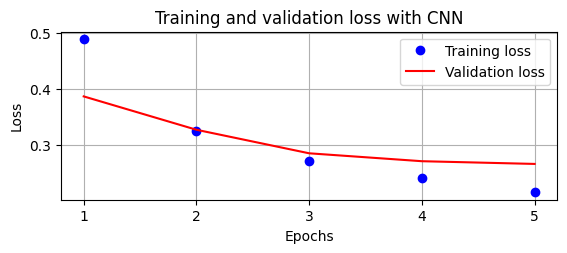

<ipython-input-24-7a9e3eea833f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


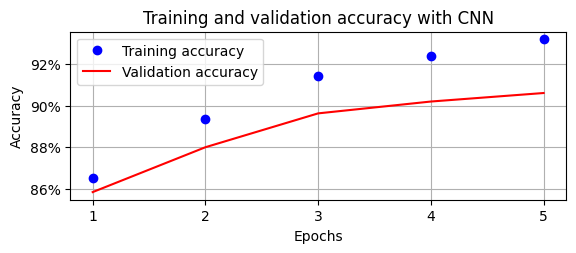

In [24]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

- 이미지를 이동시켰을 때, 성능이 어떻게 변화하는지 확인

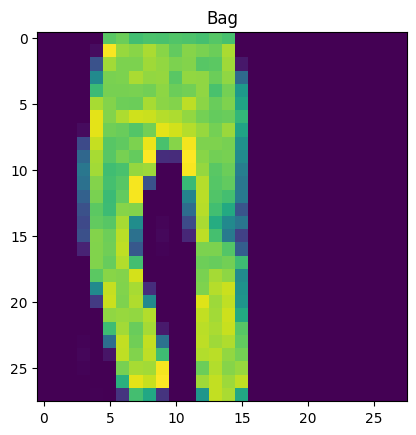

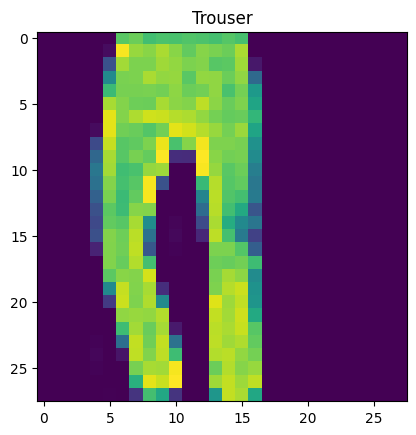

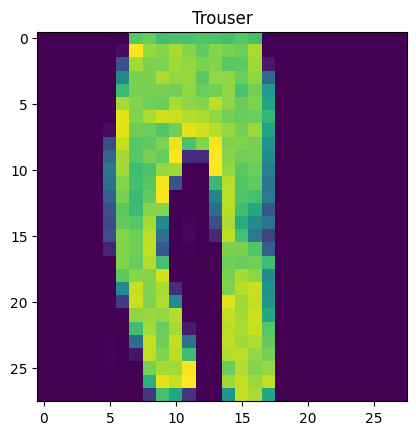

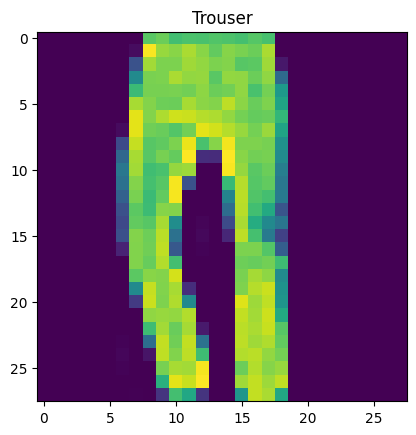

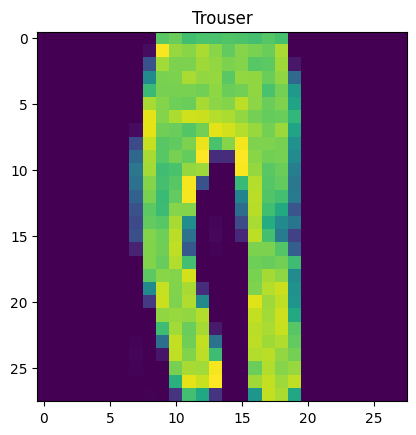

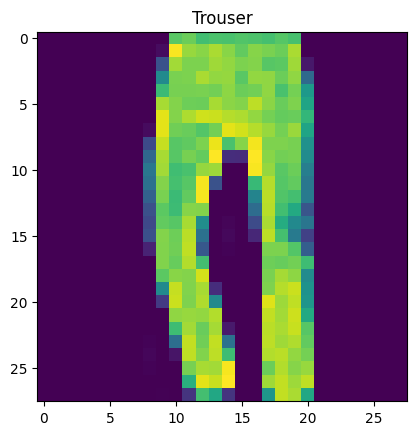

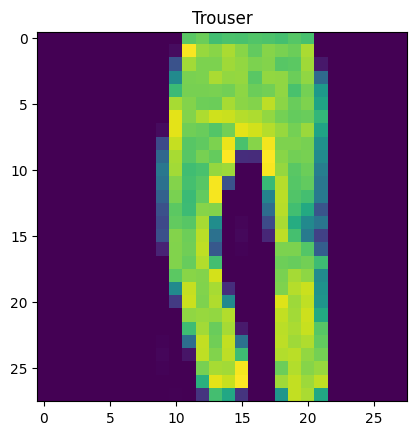

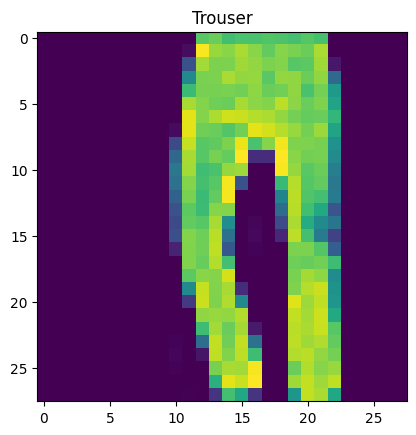

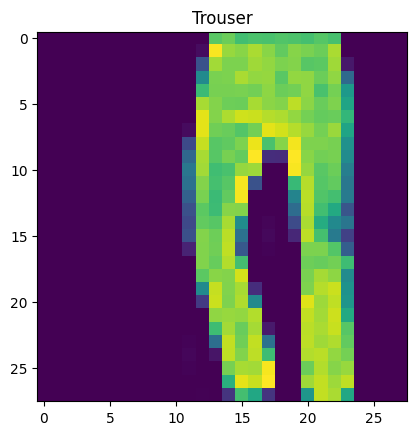

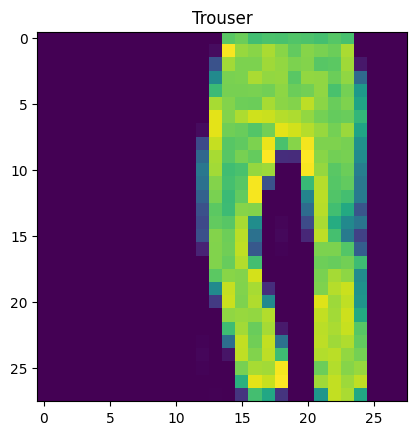

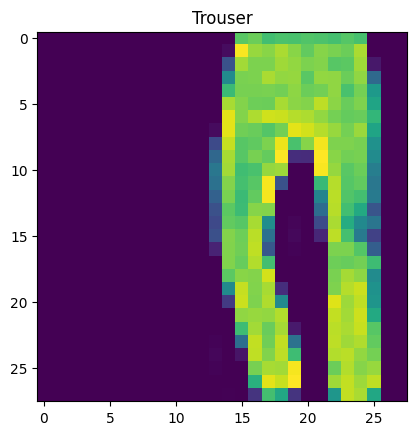

In [25]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [26]:
np.array(preds).shape # -5~+5로 이동시켜 가며(총 11 case), 10개 class로 분류될 확률 예측

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

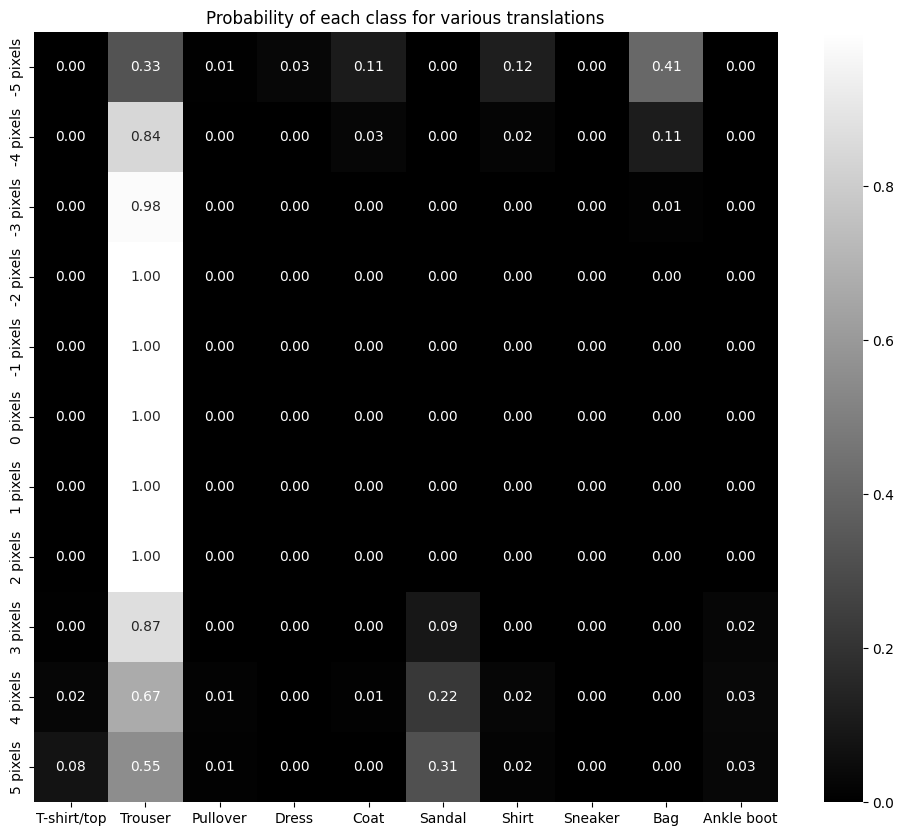

In [27]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

- 위 FC 신경망의 인사이트와 비교해서, 인사이트를 작성해주세요.

In [ ]:
# FC 신경망과 비교해서 이미지가 이동하더라도 클래스에 대한 확률이 상대적으로 일관성 있게 유지된다.
# 이는 CNN이 FC 신경망보다 공간적 변화에 더 강하기 때문이라고 볼 수 있다.
 #전반적으로 일관된 확률을 유지하며 FC 신경망에 비해서 더 안정적이고 신뢰할 수 있다.

# 3 ResNet BasicBlock 구현

- ResNet Basic Block 구현 과제 입니다.
- conv Sequential layer에는 Conv2d, ReLU를 포함해주세요.
- 순전파 함수에는 Skip Connection을 구현해주세요.

In [43]:
class ResLayer(nn.Module):
     def __init__(self,input,output,kernel_size=3,stride=1,padding=1):
        super(ResLayer, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input, output, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output),  # Batch Normalization layer 추가
            nn.ReLU(inplace=True),
            nn.Conv2d(output, output, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output)  # 두 번째 Batch Normalization layer 추가
        )

     def forward(self, x):
        identity = x  # 입력 x를 identity 변수에 저장
        out = self.conv(x)  # 입력 x를 conv 레이어에 통과시킴
        out += identity  # 결과에 입력을 더해줌
        out = nn.ReLU()(out)  # 최종 출력에 ReLU 적용
        return out